In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
!pip install -q seaborn
!pip install -q matplotlib

In [2]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, log
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

Original count of rows: 6362620

Count of rows after removing last 1000: 636000

Unique values in 'nameOrig': 635908 

Unique values in 'nameDest': 275467 

+-----+-----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
| step| type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+-----+-----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|false|false| false|   false|        false|         false|   false|         false|         false|  false|         false|
|false|false| false|   false|        false|         false|   false|         false|         false|  false|         false|
|false|false| false|   false|        false|         false|   false|         false|         false|  false|         false|
|false|false| false|   false|        false|         false|   false|         false|         false|  false|         fal

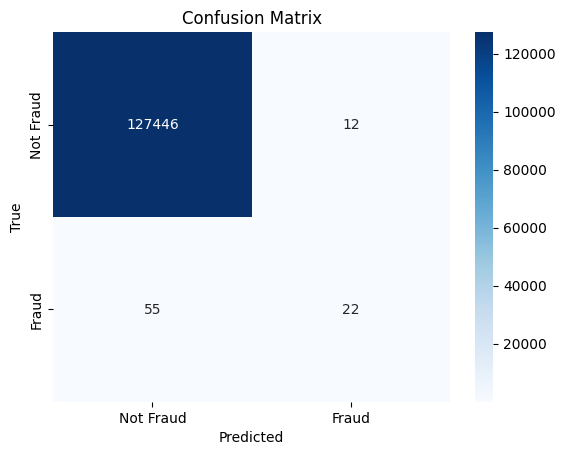

Classification report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    127458
           1       0.65      0.29      0.40        77

    accuracy                           1.00    127535
   macro avg       0.82      0.64      0.70    127535
weighted avg       1.00      1.00      1.00    127535

Models and transformers saved. Model path: fraud_detection_model



In [4]:
# Set environment variables for PySpark
os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 28g pyspark-shell'

# Initialize Spark session
spark = SparkSession.builder \
    .appName('FraudDetection') \
    .master("local[*]") \
    .config("spark.driver.memory", "32g") \
    .config("spark.executor.memory", "32g") \
    .getOrCreate()

# Load the data
path = "Fraud.csv"
fraud = spark.read.csv(path, header=True, inferSchema=True, multiLine=True, escape='"')

# Count the original number of rows
original_count = fraud.count()
print(f"Original count of rows: {original_count}\n")

# Remove the last 1000 rows
if original_count > 636000:
    filtered_fraud = fraud.limit(636000)
else:
    print("Not enough rows to remove 1000.\n")
    filtered_fraud = fraud  # Keep all rows if less than 1000

# Display the count of rows after filtering
filtered_count = filtered_fraud.count()
print(f"Count of rows after removing last 1000: {filtered_count}\n")

# Checking unique values for nameOrig and nameDest columns
print("Unique values in 'nameOrig':", filtered_fraud.select('nameOrig').distinct().count(), "\n")
print("Unique values in 'nameDest':", filtered_fraud.select('nameDest').distinct().count(), "\n")

# Check for null values
filtered_fraud.select([col(c).isNull().alias(c) for c in filtered_fraud.columns]).show()
print("Checked for null values in each column.\n")

# Fraud transaction statistics
total_count = filtered_fraud.count()
legit_transaction = filtered_fraud.filter(filtered_fraud.isFraud == 0).count()
fraud_transaction = filtered_fraud.filter(filtered_fraud.isFraud == 1).count()
print("Transaction statistics completed.\n")
legit_percent = (legit_transaction / total_count) * 100
fraud_percent = (fraud_transaction / total_count) * 100

print(f"Total Legit transactions: {legit_transaction}\n")
print(f"Total Fraud transactions: {fraud_transaction}\n")
print(f"Percentage of Legit transactions: {legit_percent:.4f}%\n")
print(f"Percentage of Fraud transactions: {fraud_percent:.4f}%\n")

# Analyzing fraud by transaction type
grouped_df = filtered_fraud.groupBy('type', 'isFraud').count().toPandas()
print("Fraud analysis by transaction type:\n")
print(grouped_df.pivot(index='type', columns='isFraud', values='count'), "\n")

# Label Encoding categorical columns
indexer = StringIndexer(inputCol="type", outputCol="typeIndex")
filtered_fraud = indexer.fit(filtered_fraud).transform(filtered_fraud)

indexer_nameDest = StringIndexer(inputCol="nameDest", outputCol="nameDestIndex")
filtered_fraud = indexer_nameDest.fit(filtered_fraud).transform(filtered_fraud)

# Create new features: diffDist and diffOrg
filtered_fraud = filtered_fraud.withColumn("diffDist", col("oldbalanceDest") - col("newbalanceDest"))
filtered_fraud = filtered_fraud.withColumn("diffOrg", col("oldbalanceOrg") - col("newbalanceOrig"))
print("Created new features: 'diffDist' and 'diffOrg'.\n")

# Ensure non-negative values for log transformation
for col_name in ['amount', 'oldbalanceDest', 'newbalanceDest', 'oldbalanceOrg', 'newbalanceOrig']:
    min_value = filtered_fraud.agg({col_name: "min"}).collect()[0][0]
    shift_value = abs(min_value) + 1 if min_value <= 0 else 0
    filtered_fraud = filtered_fraud.withColumn(col_name, log(col(col_name) + shift_value))

# Drop irrelevant columns
filtered_fraud = filtered_fraud.drop('nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest')
print("Dropped irrelevant columns.\n")

# Assembling features for the model
feature_cols = ['amount', 'diffDist', 'diffOrg', 'typeIndex', 'nameDestIndex']
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
filtered_fraud = assembler.transform(filtered_fraud)
print("Encoded features for model.\n")

filtered_fraud = filtered_fraud.repartition(1000)

# Standardizing features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
filtered_fraud = scaler.fit(filtered_fraud).transform(filtered_fraud)
print("Standardized features.\n")

# Split the data into train and test sets
train_data, test_data = filtered_fraud.randomSplit([0.8, 0.2], seed=42)

# Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="scaledFeatures", maxDepth=3)
model = dt.fit(train_data)

# Predictions
predictions = model.transform(test_data)

# Evaluation metrics
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)
print(f"Model Accuracy: {accuracy:.4f}\n")

evaluator_precision = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)
print(f"Model Precision: {precision:.4f}\n")

evaluator_recall = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)
print(f"Model Recall: {recall:.4f}\n")

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="isFraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f"Model F1 Score: {f1_score:.4f}\n")

# Confusion Matrix
y_true = predictions.select("isFraud").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Generate confusion matrix and display it
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification report
print("Classification report:\n")
print(classification_report(y_true, y_pred))

# Save models and scalers
indexer.write().overwrite().save("type_indexer")
indexer_nameDest.write().overwrite().save("nameDest_indexer")
assembler.write().overwrite().save("assembler")
scaler.write().overwrite().save("scaler")
model_path = "fraud_detection_model"
model.save(model_path)
print(f"Models and transformers saved. Model path: {model_path}\n")

# Stop Spark session
spark.stop()